Run using keras kernel!

In [60]:
from itertools import zip_longest
import cv2
import numpy as np
import csv

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def load_image(f):
    img = cv2.imread(f,-1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img 
    
def generator(n, img_dir, log):
    with open(log, 'r') as f:
        for lines in grouper(f, n, ''):
            xs = []
            ys = []
            for line in lines:
                if len(line) > 0 :
                    s = line.split(',')
                    ys.append(s[3])
                    img = load_image(img_dir+s[0])
                    xs.append(img)
            yield np.asarray(xs), np.asarray(ys)

def extract_csv(log):
    fs = []
    ys = []
    with open(log,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            fs.append(row[0])
            ys.append(row[3])
    return fs, ys

            
def generator2(n, img_dir, log):
    f, y = extract_csv('data/driving_log_3.csv')
    l = len(f)
    while True:
        xs = []
        ys = []
        for _ in range(n):
            i = np.random.randint(low=0,high=l)
            img = load_image(img_dir+f[i])
            xs.append(img)
            ys.append(y[i])
        yield (np.asarray(xs), np.asarray(ys))


mygen = generator2(2, 'data/images_run01/','data/driving_log_3.csv')
 
x,y = mygen.__next__()
print(y)
print(x[0].shape)

['0' '-0.3837616']
(160, 320, 3)


(160, 320, 3)

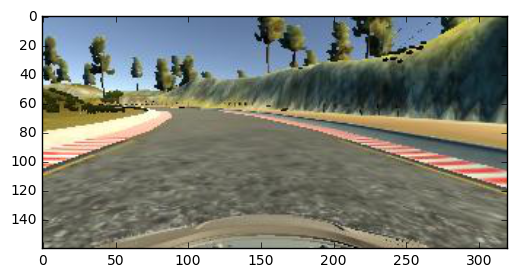

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x[0])
x[0].shape

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam 

def get_model():
    ch, row, col = 3, 160, 320  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=( row, col, ch),
            output_shape=( row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    my_adam = Adam(lr=0.00001)
    model.compile(optimizer=my_adam, loss="mse")

    return model

model = get_model()
model.fit_generator(
    #generator2(100, 'data/images_run01/','data/driving_log.csv'),
    generator2(1, 'data/images_run01/','data/driving_log_3.csv'),
    samples_per_epoch=3,
    nb_epoch=10)

# Training error for now - just to test process
g = generator2(3, 'data/images_run01/','data/driving_log_3.csv')
x,y = g.__next__()
model.evaluate(x, y)               

Epoch 1/10
3/3 [==============================] - 1s - loss: 0.0516     
Epoch 2/10
3/3 [==============================] - 0s - loss: 0.0604     
Epoch 3/10
3/3 [==============================] - 0s - loss: 0.0543     
Epoch 4/10
3/3 [==============================] - 0s - loss: 0.1519     
Epoch 5/10
3/3 [==============================] - 0s - loss: 0.0315     
Epoch 6/10
3/3 [==============================] - 1s - loss: 0.0529     
Epoch 7/10
3/3 [==============================] - 0s - loss: 0.0100     
Epoch 8/10
3/3 [==============================] - 0s - loss: 0.0067     
Epoch 9/10
3/3 [==============================] - 0s - loss: 0.0094     
Epoch 10/10
3/3 [==============================] - 0s


0.0029910299926996231